# Sun glint identification and removal

__What does this notebook do?__ This notebook identifies and corrects for sun glints over deep ocean using the method of [Hedley _et al._ (2005)](https://doi.org/10.1080/01431160500034086). This method assumes that all near-infra red (nir) reflectance above a minimum value results from sun glint over deep ocean. If it is assumed that nir reflectance is linearly proportional to red, green, and blue (rgb) reflectance, then the reflectance due to sun glint can be removed from the rgb bands by quantifying this linear relationship. Thus, sun glint is removed using the equation: 

\begin{align}
\ R_{i(deglinted)} = R_i - x(R_{nir}-min_{nir})
\end{align}

where $R$ is reflectance, $i$ is the band of interest, and $x$ is the slope of a linear regression of nir and rgb reflectance data. Figure 1 (from Hedley _et al._, 2005) demonstrates this. 

<img src="hedley_method_figure.PNG" width="500">

_Figure 1. Hedley_ et al. _(2005) glint correction method (from Hedley_ et al._, 2005)._

[Harmel _et al._ (2018)](https://doi.org/10.1016/j.rse.2017.10.022) present a novel glint correction method that does not rely on an estimation of minimum nir reflectance, or on the assumption that non-glinted pixels are present in an area of interest. However, this method would be difficult to implement for DEA because knowledge of solar and satellite viewing angles, wave height, and sun radiance at the time of image capture are required, and because atmospheric correction is included in the glint correction algorithm and cannot  be easily separated. 

__Workflow:__ Using this notebook, an image is first selected for sun glint identification and removal. To identify sun glint in the image, deep-ocean areas are then selected (either by drawing a polygon or selecting subplots from within the image that contain only deep ocean). Next, glint is identified and corrected for. There are then options to plot the uncorrected and corrected data and imagery for comparison, and to export the corrected data as a Geotiff. This workflow is summarised in Figure 2:

<img src="workflow_diagram.png" width="475">

_Figure 2. Workflow for sun glint identification and removal using this notebook._

Note that throughout the notebook, <font color = 'red'> __headings in red__ </font> indicate locations where user inputs are required before running the code. 

__Date:__ May 2018

__Author:__ Snowy Haiblen (written during a graduate rotation, feel free to contact me for further info (Anna.Haiblen@ga.gov.au))

## Load modules

In [43]:
# Import modules
import sys
import datacube
import numpy as np
import matplotlib.pyplot as plt
import pandas
import xarray as xr
import itertools
import matplotlib.patches as mpatches
import plotly.plotly as py
import ipywidgets as widgets
import fiona
import osr

from matplotlib.pyplot import imshow
from skimage import exposure
from datacube.storage import masking
from sklearn.linear_model import LinearRegression
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps)
from traitlets import link
from datacube.utils import geometry
from shapely.geometry import mapping, Polygon
from shapely.wkt import loads
from osgeo import ogr
from osgeo import osr
from datacube.utils import geometry
from datacube.helpers import write_geotiff

# Import DEA Notebooks scripts
sys.path.append('../Scripts')
import DEADataHandling
import SpatialTools
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='load-data-example')

## <font color = 'red'>User inputs: area of interest, product, time range, and cloud free fraction </font>

In [64]:
# Enter details of the imagery that you are interested in

# Area of interest:
lat_min = -22.42 #up
lat_max = -22.52 #down
lon_min = 152.00 #left
lon_max = 152.10 #right

# Product (eg. 'ls8_nbar_albers'), and related pixel quality (pq) product (eg. 'ls8_pq_albers')
product = 'ls8_nbar_albers'
pq_product = 'ls8_pq_albers'

# Time range of interest ('yyyy-mm-dd')
start = '2015-01-01'
end = '2016-01-01'

# Specify a threshold value for the minimum fraction of the image that is cloud free. Images with a greater fraction of
# cloud cover will not be displayed. 
cloud_free_fraction = 0.95

# File path for the folder where outputs will be storted. Change this to a location of your choice
file_path = '/g/data/u46/users/ah3144/dea-notebooks/Glint/'

## Load bands, correct for no-data pixels and image overlap, remove clouded imagery, and plot all available true-colour images for the specified time range

Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning:

invalid value encountered in reduce



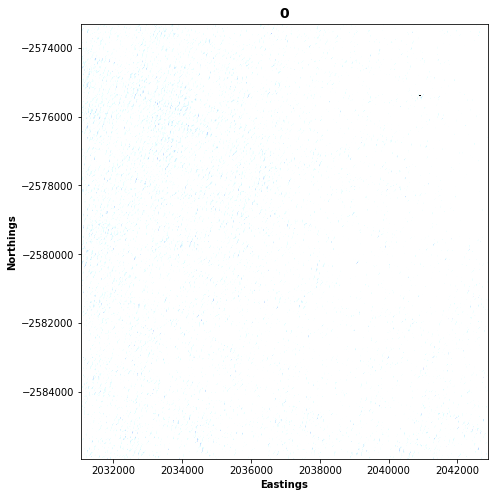

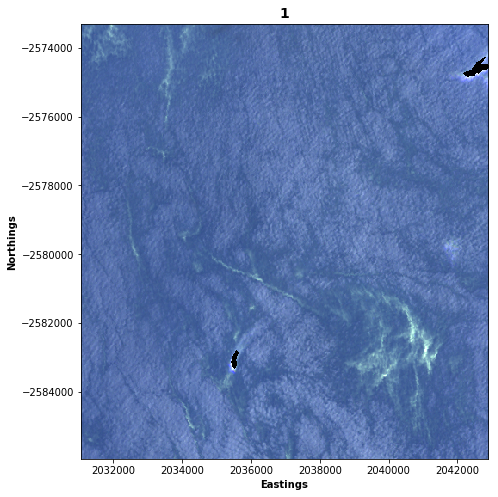

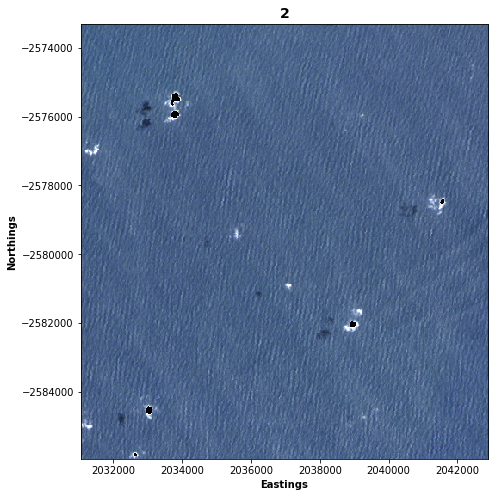

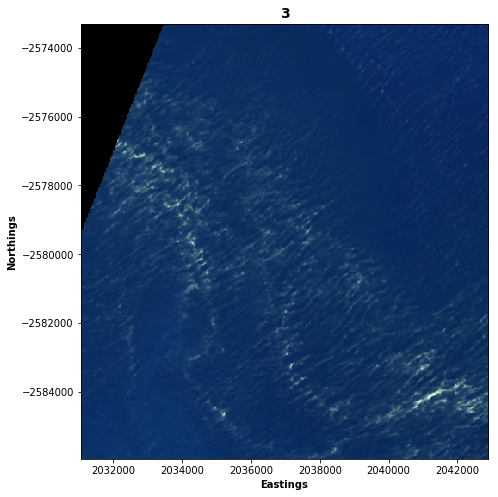

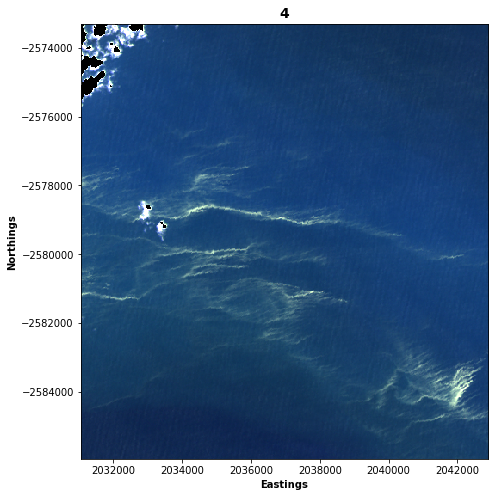

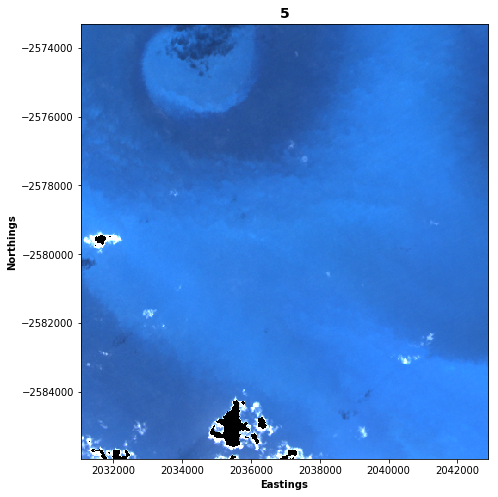

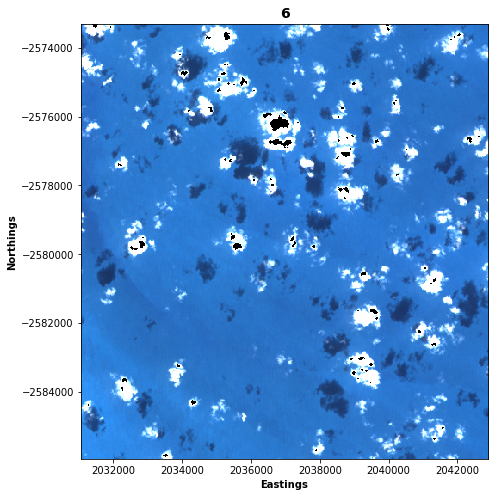

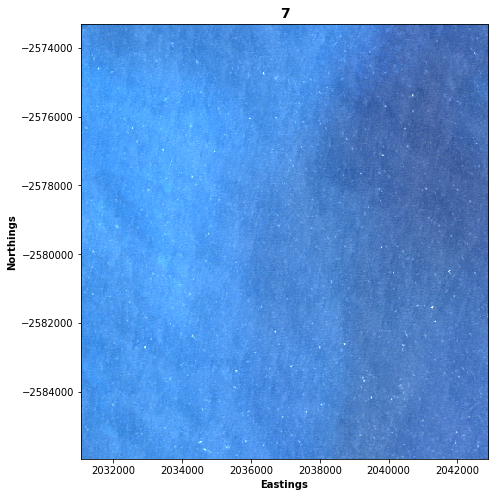

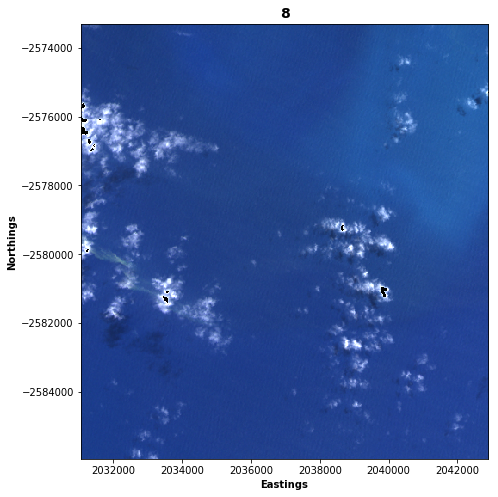

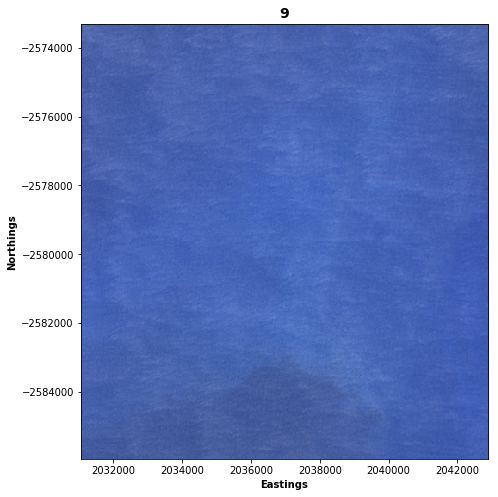

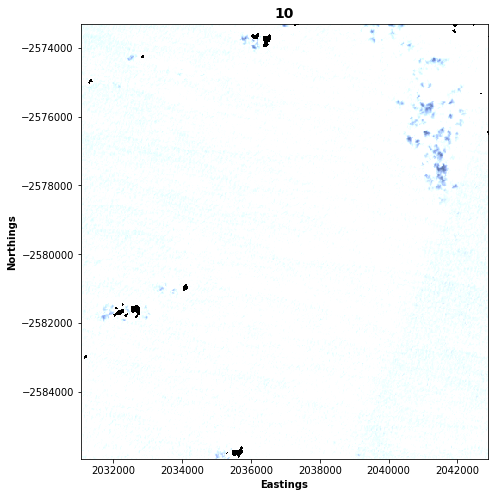

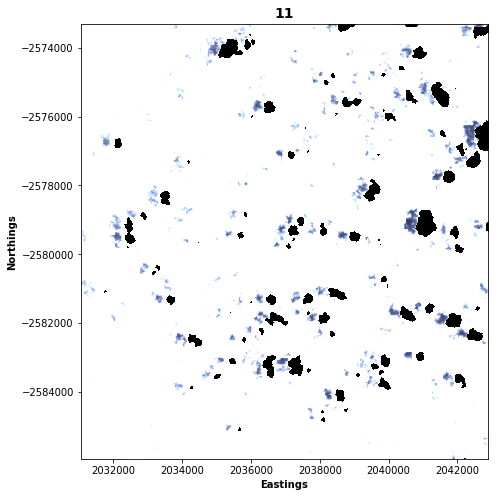

In [65]:
# Define a query for loading data
query = {
        'lat': (lat_min, lat_max),
        'lon': (lon_min, lon_max),
        'time':(start, end)
        }

# Load data from the datacube and label the data object 'dataset'
dataset, crs, affine = DEADataHandling.load_nbarx(dc=dc,
                         sensor = 'ls8',
                         query=query,
                         bands_of_interest = ['red', 'green', 'blue', 'nir'])

# Remove all images where the cloud free fraction is less than the threshold value
pq = dc.load(product = pq_product, 
               x=(lon_min, lon_max), y=(lat_min, lat_max),
               time=(start, end), group_by='solar_day')
pq_toplot = pq.pixelquality
cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_fraction
data_mostly_cloud_free = dataset.where(mostly_cloud_free).dropna('time', how='all')

# Define data arrays for each band of interest
nir = data_mostly_cloud_free.nir
red = data_mostly_cloud_free.red
green = data_mostly_cloud_free.green
blue = data_mostly_cloud_free.blue

# Plot all images that fits the specified criteria. Increase/decrease the 'reflect_stand' value to darken/lighten the
# imagery
n = len(list(data_mostly_cloud_free['time']))
for i in range(0,n):
    DEAPlotting.three_band_image(data_mostly_cloud_free, bands=['red', 'green', 'blue'], time=i, figsize=(8, 8), title=i,
                     projection='projected', contrast_enhance=False, reflect_stand=600)

## <font color = 'red'>Select an image for glint identification and removal </font>

In [66]:
# Enter the heading number for the image that you are interested in from the output of images above
image = 2

## Select deep-ocean area(s) within the selected image for glint correction
## <center>by EITHER:</center>
## <center><font color = 'red'>Drawing a polygon</font> _OR_ <font color = 'red'>Selecting deep-ocean subplots</font></center>

Run the cells under the title <font color = 'red'>**Polygon method**</font> to select deep ocean areas by drawing a polygon on a map of the area. Alternatively, scroll down to the title <font color = 'red'>**Subplot method**</font> and run the cells below this. 

___

### <center><font color = 'red'>*******Polygon method*******</font></center>
Run the cell below this, then draw a polygon over deep ocean that is within the area of the image for glint correction. Note:
* Do not included clouded pixels or pixels that have been removed because of cloud within your polygon. This will result in errors further down the workflow. 
* Drawing a larger polygon will mean that your glint correction is based on more data, and, therefore, is more accurate. 

Click on the polygon symbol, then draw a polygon over deep ocean areas that are cloud free
and do not contain no-data pixels.
Note: the scale and exent of the two images is not identical.


Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9c5be0a898>)

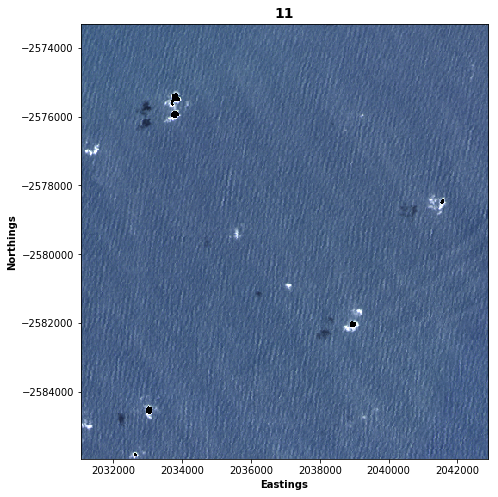

In [67]:
# Code from Vanessa Newey

# Define the position and size of the imagery to import for drawing a polygon (it is not possible to make the image size
# exactly match that of the image for glint correction)
center = [(lat_min + ((lat_max - lat_min)/2)), (lon_min + ((lon_max - lon_min)/2))]
zoom = 12

# Define a map object 'm' with a specified projection and basemap
m = Map(projection='aea', center=center, zoom=zoom,layout=dict(width='400px', height='400px'),
        basemap=basemaps.Esri.WorldImagery)

# Remind the user to draw a polygon on the image
print ("Click on the polygon symbol, then draw a polygon over deep ocean areas that are cloud free")
print ("and do not contain no-data pixels.")
print ("Note: the scale and exent of the two images is not identical.")

# Create the DrawControl and add it to the image using add_control
draw_control = DrawControl(polyline={})
m.add_control(draw_control)

# Display an image for drawing a polygon on
display(m)

# Also display the image for glint correction to check where clouds and no-data pixels are present
DEAPlotting.three_band_image(data_mostly_cloud_free, bands=['red', 'green', 'blue'], time=image, figsize=(8, 8), title=i,
                     projection='projected', contrast_enhance=False, reflect_stand=600)

#### Create a polygon from the shape drawn above, and save it in the same coordinate reference system as the datacube data

In [68]:
# Code from Vanessa Newey

# Convert the coordinate reference system for the polygon drawn above to match that used for datacube imagery
geom_crs = geometry.CRS('EPSG:4326')
drawn_geom=geometry.Geometry(draw_control.last_draw['geometry'], geom_crs)
source = osr.SpatialReference()
source.ImportFromEPSG(4326)
target = osr.SpatialReference()
target.ImportFromEPSG(3577)
transform = osr.CoordinateTransformation(source, target)
poly = ogr.CreateGeometryFromWkt(drawn_geom.wkt)
poly.Transform(transform)

# Export the polygon as a shapefile. Print 'True' if the export is successful. ***change the file path to suit your
# needs***
shapely_poly = loads(poly.ExportToWkt())
output_shpfile = file_path + 'deep_water_area.shp'

schema = {
   'geometry': 'Polygon',
   'properties': {'id': 'int',
                   'name': 'str'},
}

try:
   with fiona.open(output_shpfile, 'w', 'ESRI Shapefile', schema, crs = {'init': 'epsg:3577', 'no_defs': True}) as c:  
       c.write({
             'geometry': mapping(shapely_poly),
             'properties': {'id': 1,
                            'name': 'drawn_polygon'},
         })
except:
   print(c.closed)
   raise
c.closed

True

#### Rasterise the shapefile and plot the part of the image for glint correction that is within the polygon drawn above
<font color = 'red'>After running this cell, check that the polygon is within your area of interest and covers only cloud-free, deep ocean areas. 

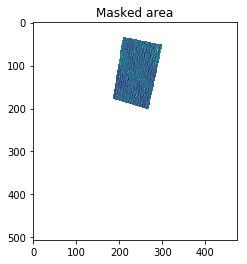

In [69]:
# Code from Chad Burton and Robbi Bishop-Taylor

# Find the 'wkt' for GDA94 Albers Equal Area
srs = osr.SpatialReference()
srs.ImportFromEPSG(3577)
prj_wkt = srs.ExportToWkt()

# Find the width and height of the image for glint correction
width,height = nir.isel(time=image).shape

# Create a 'transform' tuple that will define the dimensions of the rasterized shapefile as those of the image for
# glint correction
easting = float(nir.x[0])
W_E_pixelRes = float(nir.y[0] - nir.y[1])
rotation = 0.0 #(if image is 'north up')
northing = float(nir.y[0])
rotation1 = 0.0 #(if image is 'north up')
N_S_pixelRes = float(nir.x[0] - nir.x[1])
transform = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

# Locate the shapefile for rasterisation. ***change the file path to suit your needs***
shapefile_path = file_path + 'deep_water_area.shp'

# Rasterise the shapefile
raster_deep_water_area = SpatialTools.rasterize_vector(shapefile_path, height, width, transform, prj_wkt, 
                                                       raster_path=None)

# Plot the part of the image for glint correction that is within the shapefile area
plt.figure()
plt.title('Masked area')
imshow(red.isel(time=image).where(raster_deep_water_area > 0))

### <center><font color = 'red'>*******OR: Subplot method*******</font></center>

#### Grid the image for glint correction into 5x5 subplots

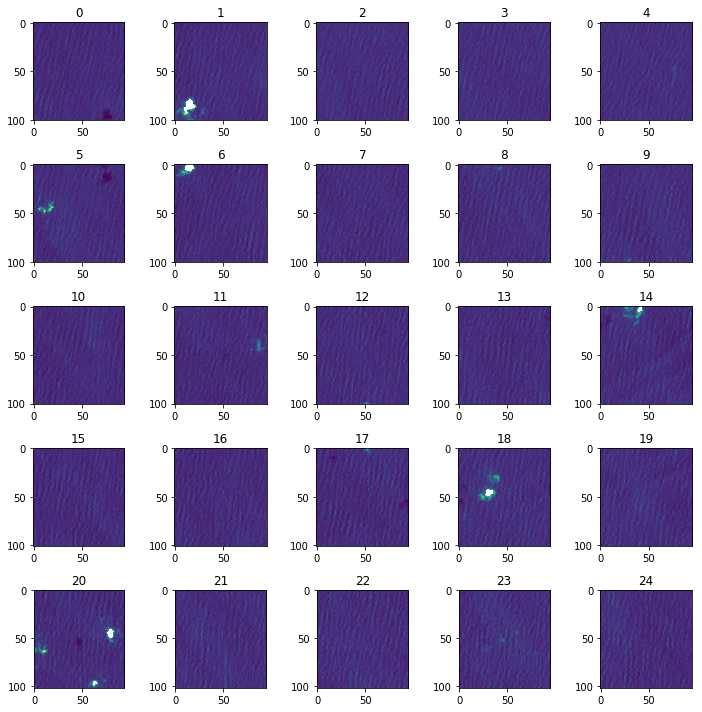

In [70]:
# Written with lots of help from Imam Alam!

# Find the number of rows and columns of pixels within the image for glint correction
pixels_in_x = red.shape[2]
pixels_in_y = red.shape[1]

# Define a function to create subplots that have a fifth of the width and height of the image for glint correction
def break_up_plot(array,a,b):
    imshow(array.isel(x=slice((int (a*pixels_in_x)),(int ((a + 0.2)*pixels_in_x))),
                                y=slice(int (b*pixels_in_y),(int ((b + 0.2)*pixels_in_y))), time=image) , 
       vmin=np.min(array.isel(time=image)), vmax=np.max(array.isel(time=image)))

# Plot imagery for each of the 25 equally-sized parts of the image for glint correction and assign each subplot an
# integer value as a title
plt.figure(figsize = (10,10))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i * 5 + j + 1)
        plt.title(i * 5 + j)
        break_up_plot(red, j * 0.2, i * 0.2)
plt.tight_layout()

#### <font color = 'red'>Enter the title number for subplots that are 100% deep ocean in the list below</font>

Listing a greater number of subplots will mean that glint correction is based on more data. Do not include subplots with any cloud or no-data pixels.

In [71]:
# Enter title numbers for subplots that are 100% deep ocean
deep_ocean_subplots = [2, 3, 7, 10, 12, 13, 15, 16, 19, 21, 22]

#### Create lists of all rgb and nir reflectance values for all pixels in selected deep-ocean subplots

In [72]:
#############################################################################################
# Identity selected subplots by their position in the the overall image for glint correction
#############################################################################################

# Define a function to round numbers down to the nearest multiple of five
def round_down(num):
    return num - (num%5)

# Define a function to calculate the position of a subplot within the overall image for glint correction based on it's
# title
def select_subplot(data):
    i = float (("%.1f" % ((data - round_down(data))/5)))
    j = round_down(data) / 25
    ij=[i,j]
    return ij

# Create an array that contains the position of each listed subplot within the overall image for glint correction
subplot_locations = []
for i in deep_ocean_subplots:
    x = select_subplot(i)
    subplot_locations.append(x)

###########################################################################################
# Create a list of data arrays that contain reflectance data for each band in each subplot
###########################################################################################

# Define a function that creates a 1D (stacked) array of reflectance data for one band in one subplot
def deep_ocean_data(array,a):
    return ((array.isel(x=slice((int (a[0]*pixels_in_x)),(int ((a[0] + 0.2)*pixels_in_x))),
                                y=slice(int (a[1]*pixels_in_y),(int ((a[1] + 0.2)*pixels_in_y))), time=image)))

# List the bands of interest (these are the arrays containing the reflectance data)
bands = [nir, red, green, blue]

# Loop through the deep_ocean_data function for each specified subplot and create a list of arrays with data for 
# each band in each subplot
all_deep_ocean_data = []
for i in bands:
    for j in subplot_locations:
        x = deep_ocean_data(i,j)
        all_deep_ocean_data.append(x)

######################################################################################################################
# Reogranise the data so that a single list of all reflectance data for deep ocean areas can be created for each band
######################################################################################################################

# Create lists to indicate which data arrays within the dataset correspond to which band
colours_x_images = len (deep_ocean_subplots) *4
nir_list = list(range(1,int(colours_x_images/4+1)))
red_list = list(range(int(colours_x_images/4+1),int(colours_x_images*2/4+1)))
green_list = list(range(int(colours_x_images*2/4+1), int(colours_x_images*3/4+1)))
blue_list = list(range(int(colours_x_images*3/4+1), int(colours_x_images*4/4+1)))

# Define a function to reduce data in lists within lists to a single list
def reduce_list_to_one_d(a):
    two_d = list(itertools.chain.from_iterable(a))
    return (list(itertools.chain.from_iterable(two_d)))

# Define a function to join all data from all_deep_ocean_data for the same band into a single list
def final_list(a):
    joined = []
    for i in a:
        x = reduce_list_to_one_d(np.asarray(all_deep_ocean_data[i-1:i]))
        joined.append(x)
    only_deep = list(itertools.chain.from_iterable(joined))
    return (only_deep)

### <font color = 'red'>Run ONE of the two cells below (depending on which deep-ocean selection method you used)</font>
These cells create arrays of all deep-ocean reflectance values for each band. 

In [50]:
#################
# Polygon method
#################

# Mask all data for each band using the polygon created above so that data for pixels outside of the polygon area is
# assigned a value of -999, then stack all data for each band into a 1D array
nir_masked_stacked = np.hstack(nir.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))
red_masked_stacked = np.hstack(red.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))
green_masked_stacked = np.hstack(green.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))
blue_masked_stacked = np.hstack(blue.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))

# Remove data from each array that is for pixels outside of the polygon area
nir_deep = np.extract((nir_masked_stacked >= 0), nir_masked_stacked)
red_deep = np.extract((red_masked_stacked >= 0), red_masked_stacked)
green_deep = np.extract((green_masked_stacked >= 0), green_masked_stacked)
blue_deep = np.extract((blue_masked_stacked >= 0), blue_masked_stacked)

In [73]:
#################
# Subplot method
#################

# Create 1D arrays of all deep-ocean reflectance data for each band using the 'final_list' function defined above
nir_deep = np.asarray(final_list(nir_list))
red_deep = np.asarray(final_list(red_list))
green_deep = np.asarray(final_list(green_list))
blue_deep = np.asarray(final_list(blue_list))

## Identify and remove glint

### Find the linear best-fit line for each of the rgb bands against the nir band, then plot the results

red gradient:    0.9766794051867439
red y-intercept: 15.267700207641553
blue gradient:    0.8530068153290107
blue y-intercept: 182.5885870713833
green gradient:    0.9427739984631233
green y-intercept: 78.9997242760258


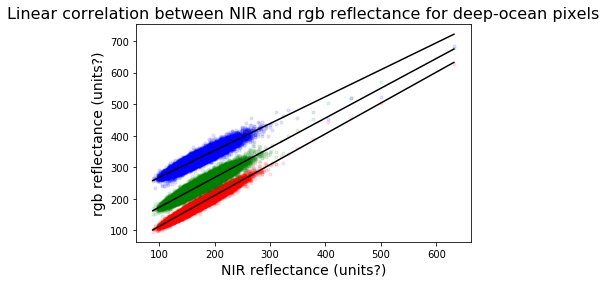

In [74]:
# Define arrays of reflectance data as x and y for plotting
x = nir_deep
y1 = red_deep
y2 = blue_deep
y3 = green_deep

# Calculate linear best fit lines
red_model = LinearRegression()
blue_model = LinearRegression()
green_model = LinearRegression()
red_model.fit(x[:, np.newaxis], y1)
blue_model.fit(x[:, np.newaxis], y2)
green_model.fit(x[:, np.newaxis], y3)

# Define x and y values for the best fit lines for plotting, and specify that the x range for the resulting plots will be
# equal to the range of nir_deep values
xfit = np.linspace(min(nir_deep), max(nir_deep))
y1fit = red_model.predict(xfit[:, np.newaxis])
y2fit = blue_model.predict(xfit[:, np.newaxis])
y3fit = green_model.predict(xfit[:, np.newaxis])

# Plot the data and the best fit line
plt.title('Linear correlation between NIR and rgb reflectance for deep-ocean pixels', fontsize = 16)
plt.xlabel('NIR reflectance (units?)', fontsize = 14)
plt.ylabel('rgb reflectance (units?)', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.scatter(x, y1, s = 10, color = 'red', alpha = 0.1)
plt.plot(xfit, y1fit, color = 'black')
plt.scatter(x, y2, s = 10, color = 'blue', alpha = 0.1)
plt.plot(xfit, y2fit, color = 'black')
plt.scatter(x, y3, s = 10, color = 'green', alpha = 0.1)
plt.plot(xfit, y3fit, color = 'black')

# Print gradient and y-intercept values for each best-fit line
print("red gradient:   ", red_model.coef_[0])
print("red y-intercept:", red_model.intercept_)
print("blue gradient:   ", blue_model.coef_[0])
print("blue y-intercept:", blue_model.intercept_)
print("green gradient:   ", green_model.coef_[0])
print("green y-intercept:", green_model.intercept_)

### Calculate the degree of glint for each pixel, then correct for glint in rgb using the Hedley _et al._ (2005) method

In [75]:
# The object 'degree_of_glint' is a proxy for the degree of glint for each pixel. It is calculated from the absolute 
# length of a line that is parallel to slope of the best fit line, from any one data point to the minimum nir value in the
# plot above. This is found using trigonometry; the first term in the expression below is the distance between the pixel
# value and the minimum nir value along the x-axis, the second term is the cosine of the angle between horizontal and best
# fit line. 
degree_of_glint = ((nir.isel(time=image))-(nir_deep.min()))/np.cos(np.deg2rad(np.rad2deg(np.arctan(red_model.coef_[0]))))

# Apply the Hedley et al. (2005) equation for glint correction to the rgb data
red_corr = red.isel(time=image)-((red_model.coef_[0])*((nir.isel(time=image))-(nir_deep.min())))
blue_corr = blue.isel(time=image)-((blue_model.coef_[0])*((nir.isel(time=image))-(nir_deep.min())))
green_corr = green.isel(time=image)-((green_model.coef_[0])*((nir.isel(time=image))-(nir_deep.min())))

# Create 'nir_corr' - an array of the same shape as red_corr (etc.) where all values equal nir_deep.min()
nir_corr = red_corr/red_corr*nir_deep.min()

## Create outputs

### Check that the glint correction has worked by plotting uncorrected and corrected deep-ocean data for visual inspection

#### Create a dataset of all corrected data for only the specified deep-ocean areas to identify data for plotting
<font color = 'red'>Run ONE of the two cells below (depending on which deep-ocean selection method you used)</font>

In [53]:
#################
# Polygon method
#################

# Mask the corrected data arrays with the polygon created above so that reflectance values are only returned within the
# polygon area, then stack all reflectance values as a 1D array
nir_corr_masked = np.hstack(nir_corr.where(raster_deep_water_area > 0))
red_corr_masked = np.hstack(red_corr.where(raster_deep_water_area > 0))
green_corr_masked = np.hstack(green_corr.where(raster_deep_water_area > 0))
blue_corr_masked = np.hstack(blue_corr.where(raster_deep_water_area > 0))

# Remove nan values from the masked arrays
nir_corr_deep = nir_corr_masked[~np.isnan(nir_corr_masked)]
red_corr_deep = red_corr_masked[~np.isnan(red_corr_masked)]
green_corr_deep = green_corr_masked[~np.isnan(green_corr_masked)]
blue_corr_deep = blue_corr_masked[~np.isnan(blue_corr_masked)]

# Create a dataset of all corrected deep-ocean data
all_corr = np.transpose(np.vstack((blue_corr_deep, green_corr_deep, red_corr_deep, nir_corr_deep, nir_deep)))

In [76]:
#################
# Subplot method
#################

# Define a function that creates a 1D (stacked) array of reflectance data for one band in one subplot (this function is 
# the same as 'deep_ocean_data', except that we do not need to specify time=image)
def deep_ocean_data_corr(array,a):
    return ((array.isel(x=slice((int (a[0]*pixels_in_x)),(int ((a[0] + 0.2)*pixels_in_x))),
                                y=slice(int (a[1]*pixels_in_y),(int ((a[1] + 0.2)*pixels_in_y))))))

# List the bands of interest (these are the arrays containing the data)
bands_corr = [nir_corr, red_corr, green_corr, blue_corr]

# Loop through the deep_ocean_data_corr function for each specified subplot and create a list of arrays with data for 
# each band in each subplot
all_corr_deep_ocean_data = []
for i in bands_corr:
    for j in subplot_locations:
        x = deep_ocean_data_corr(i,j)
        all_corr_deep_ocean_data.append(x)

# Define a function to join all data from all_deep_ocean_data for the same band into a single list
def final_corr_list(a):
    joined = []
    for i in a:
        x = reduce_list_to_one_d(np.asarray(all_corr_deep_ocean_data[i-1:i]))
        joined.append(x)
    only_deep = list(itertools.chain.from_iterable(joined))
    return (only_deep)

# Create 1D arrays of all corrected deep-ocean reflectance data for each band
nir_corr_deep = np.asarray(final_corr_list(nir_list))
red_corr_deep = np.asarray(final_corr_list(red_list))
green_corr_deep = np.asarray(final_corr_list(green_list))
blue_corr_deep = np.asarray(final_corr_list(blue_list))

# Create a dataset of all corrected deep-ocean data
all_corr = np.transpose(np.vstack((blue_corr_deep, green_corr_deep, red_corr_deep, nir_corr_deep, nir_deep)))

#### Plot uncorrected and corrected deep-ocean rgb and nir reflectance data for pixels with the lowest 100 and highest 100 uncorrected nir reflectance values

Text(0,0.5,'Reflectance (units?)')

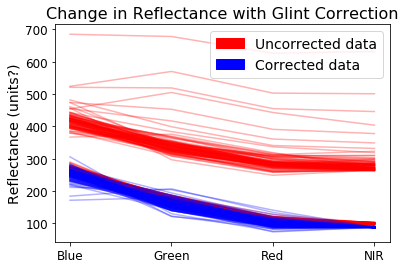

In [77]:
######################################################
# Create a dataset of all uncorrected deep-ocean data
######################################################

all_uncorr = np.transpose(np.vstack((blue_deep, green_deep, red_deep, nir_deep, nir_deep)))

###############################
# Manipulate data for plotting
###############################

# Order the rows of the uncorrected and corrected datasets from min-max nir_deep
all_uncorr_ordered = all_uncorr[all_uncorr[:,4].argsort()]
all_corr_ordered = all_corr[all_corr[:,4].argsort()]

# Take only to values for the pixels with the lowest 100 and highest 100 nir_deep values from all_uncorr and all_corr
minmax_uncorr = np.vstack(((all_uncorr_ordered[:100,:4]),(all_uncorr_ordered[-100:,:4])))
minmax_corr = np.vstack(((all_corr_ordered[:100,:4]),(all_corr_ordered[-100:,:4])))

#######################################################################################################################
# Plot the uncorrected data (red) and the corrected data (blue) for pixels with the lowest and highest nir_deep values
#######################################################################################################################

# Create a 1D array of integers and a list of band names for plotting
x_axis = np.array([0,1,2,3])
labels = ['Blue','Green','Red','NIR']

# Loop through the pixels with the lowest 100 and highest 100 nir_deep values and plot reflectance data for each band for
# each pixel
plt.xticks(x_axis, labels, fontsize = 12)
plt.yticks(fontsize = 12)
for i in range (200):
    plt.plot(x_axis, (np.transpose(minmax_corr))[:,i], color = 'blue', alpha = 0.3)
    plt.plot(x_axis, (np.transpose(minmax_uncorr))[:,i], color = 'red', alpha = 0.3)
plt.title('Change in Reflectance with Glint Correction', fontsize = 16)
red_patch = mpatches.Patch(color='red', label='Uncorrected data')
blue_patch = mpatches.Patch(color='blue', label='Corrected data')
plt.legend(handles=[red_patch, blue_patch], fontsize = 14)
plt.ylabel('Reflectance (units?)', fontsize = 14)

### Plot true-colour images for the area of interest before and after glint correction

xarray dataset has no spatial data; defaulting to plotting without coordinates. This can often be resolved by adding `keep_attrs = True` during an aggregation step


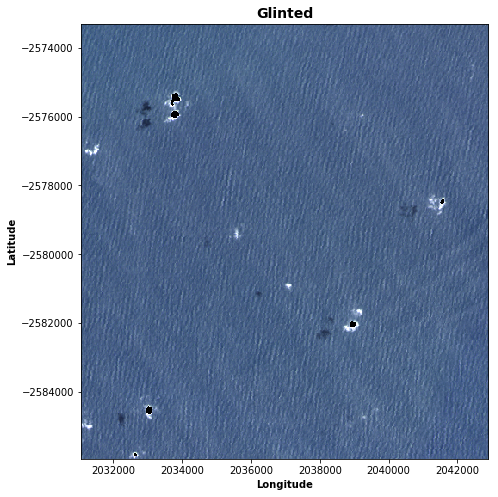

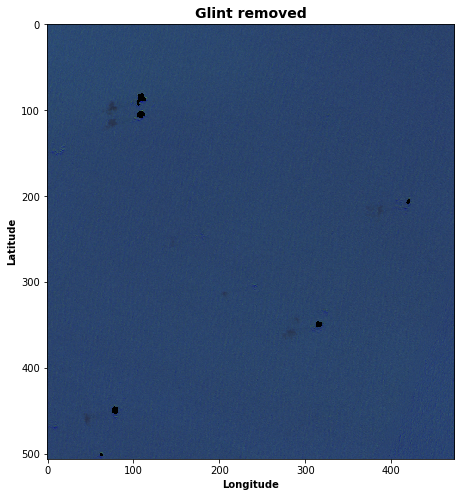

In [78]:
# Create a dataset of all corrected data
nir_corr = xr.DataArray(nir_corr, name = 'nir_corr')
red_corr = xr.DataArray(red_corr, name = 'red_corr')
green_corr = xr.DataArray(green_corr, name = 'green_corr')
blue_corr = xr.DataArray(blue_corr, name = 'blue_corr')
dataset_corr = xr.merge([red_corr, green_corr, blue_corr, nir_corr])

# Plot the original, glinted image
glinted = DEAPlotting.three_band_image(data_mostly_cloud_free, bands=['red', 'green', 'blue'], time=image, 
                                       figsize=(8, 8), title="Glinted", projection='geographic', contrast_enhance=False, 
                                       reflect_stand=600)

# Plot the image with glint removed
glint_removed = DEAPlotting.three_band_image(dataset_corr, bands=['red_corr', 'green_corr', 'blue_corr'], time=image, 
                                             figsize=(8, 8), title="Glint removed", projection='geographic', 
                                             contrast_enhance=False, reflect_stand=600)

### Export the glint-corrected image as a Geotiff

In [41]:
# Give 'dataset_corr' the same crs and affine objects as 'dataset'
dataset_corr.attrs['affine']= dataset.affine
dataset_corr.attrs['crs']= crs

# Export the deglinted image as a Geotiff. ***change the file path to suit your needs***
write_geotiff(file_path + 'glint_removed.tif', dataset_corr)